# Transfer Learning with TensorFlow Part 2: Fine-tuning
In the previous notebook, we covered transfer learning feature extraction now it's time to learn about a new kind of transfer learning: fine tuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

Mon Jun 27 05:25:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8    17W /  N/A |   1258MiB /  6144MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper funtions
In previous, we've created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here.

In [2]:
import os
if not os.path.exists("C:/Selbststudium/Udemy/Udemy_TensorFlow_Certificate/helper_functions.py"):
    !python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101.
if not os.path.exists("10_food_classes_10_percent.zip"):
    !python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [5]:
# unzip_data("10_food_classes_10_percent")
# Already existing

In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [7]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.93841843e+02 1.94586731e+02 1.89714279e+02]
   [1.95071426e+02 1.95357147e+02 1.90714279e+02]
   [1.96586731e+02 1.95357147e+02 1.93433670e+02]
   ...
   [1.48270218e+02 1.13555794e+02 1.16698738e+02]
   [1.49479721e+02 9.57194290e+01 1.08505165e+02]
   [1.61214218e+02 9.67549515e+01 1.13984566e+02]]

  [[1.97877548e+02 1.95596939e+02 1.92000000e+02]
   [1.99933670e+02 1.95862244e+02 1.92862244e+02]
   [2.00341827e+02 1.95642868e+02 1.93357147e+02]
   ...
   [1.32535751e+02 9.71631470e+01 1.03066315e+02]
   [1.51821579e+02 1.01617409e+02 1.13765404e+02]
   [1.65301041e+02 1.06040771e+02 1.23897911e+02]]

  [[2.01571426e+02 1.92642853e+02 1.91214279e+02]
   [2.02301025e+02 1.93372452e+02 1.91943878e+02]
   [2.02785721e+02 1.93168365e+02 1.92428574e+02]
   ...
   [1.47841919e+02 1.16933662e+02 1.22673485e+02]
   [1.57678558e+02 1.17663200e+02 1.28892838e+02]
   [1.48295731e+02 1.02290619e+02 1.17504898e+02]]

  ...

  [[1.94428589e+02 1.74428589e+02 1.73428589e+02]
   [1

## Model 0: Building a transfer learning model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./225.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# 10. Fit the model and save it's history
history_0 = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="10_percent_feature_extraction"
        )
    ]
)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220627-052607


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
24/24 [==============================] - 21s 301ms/step - loss: 1.9495 - accuracy: 0.3573 - val_loss: 1.4009 - val_accuracy: 0.6595
Epoch 2/5
24/24 [==============================] - 4s 174ms/step - loss: 1.1739 - accuracy: 0.7453 - val_loss: 0.9403 - val_accuracy: 0.7878
Epoch 3/5
24/24 [==============================] - 4s 175ms/step - loss: 0.8691 - accuracy: 0.7973 - val_loss: 0.7497 - val_accuracy: 0.8306
Epoch 4/5
24/24 [==============================] - 4s 175ms/step - loss: 0.7022 - accuracy: 0.8293 - val_loss: 0.6635 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 4s 180ms/step - loss: 0.6048 - accuracy: 0.8573 - val_loss: 0.5973 - val_accuracy: 0.8520


In [13]:
# Evluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 106ms/step - loss: 0.6227 - accuracy: 0.8340


[0.6227174401283264, 0.8339999914169312]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [16]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


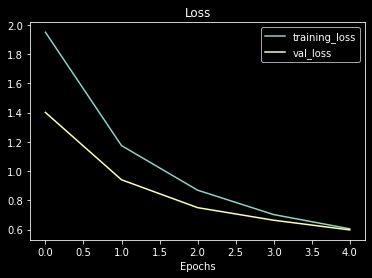

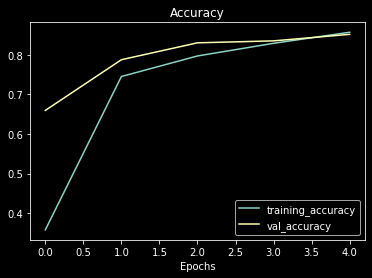

In [17]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer ...

We have a tensor after our model goes through `base_model`of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of global average pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of global average pooled 2D tensor: (1, 3)


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> 🔑 **Note:** One of the reasonst feature extraction transfer learning is named how it is because what often happes is pretrained model outputs a **feature vector** (a long tensor of number which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract pattern out of for our own specific problem.

> 🛠️ **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

In [20]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"Global max pooled tensor:\n{global_max_pooled_tensor}\n")
print(f"Shape of global max pooled layer: {global_max_pooled_tensor.shape}")

Global max pooled tensor:
[[0.9058464 1.1603122 1.6994323]]

Shape of global max pooled layer: (1, 3)


In [21]:
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** Throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for `model_1`

In [22]:
# Let's download and unzip data - preprocessed from Food101
if not os.path.exists("10_food_classes_1_percent.zip"):
    !python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
    unzip_data("10_food_classes_1_percent.zip")

In [23]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [24]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [25]:
# Setup data loaders
IMG_SIZE=(224, 224)
BATCH_SIZE=3

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentaion right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our of heads after reading the cods the benefits of using data augmentation inse the model are:
* Preprocessing of images (augmentin them) happens on the GPU (much fast) rather tan the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 428.5, 563.5, -0.5)

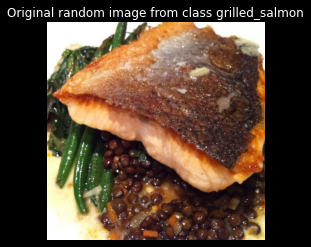

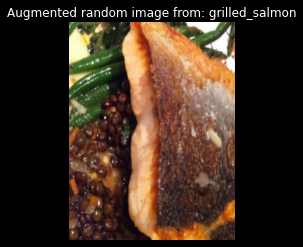

In [27]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from helper_functions import plot_loss_curves

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from: {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [28]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name="input_layer") # tf.keras.layers.input was the same, if we didn't import it as `layers`

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_ppoling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [29]:
# Fit
history_1_percent = model_1.fit(
    train_data_1_percent,
    epochs=5,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="1_percent_data_aug"
        )
    ]
)

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220627-052659
Epoch 1/5
24/24 [==============================] - 20s 628ms/step - loss: 2.3198 - accuracy: 0.2000 - val_loss: 1.9750 - val_accuracy: 0.3510
Epoch 2/5
24/24 [==============================] - 9s 396ms/step - loss: 1.6339 - accuracy: 0.6571 - val_loss: 1.6529 - val_accuracy: 0.5112
Epoch 3/5
24/24 [==============================] - 8s 359ms/step - loss: 1.1575 - accuracy: 0.8429 - val_loss: 1.4470 - val_accuracy: 0.6042
Epoch 4/5
24/24 [==============================] - 8s 331ms/step - loss: 0.8832 - accuracy: 0.9429 - val_loss: 1.2854 - val_accuracy: 0.6458
Epoch 5/5
24/24 [==============================] - 8s 354ms/step - loss: 0.6528 - accuracy: 0.9714 - val_loss: 1.1882 - val_accuracy: 0.6635


In [30]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_ppoling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [31]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

834/834 [==============================] - 18s 21ms/step - loss: 1.1811 - accuracy: 0.6772


[1.1811100244522095, 0.6772000193595886]

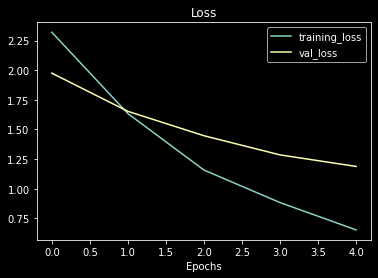

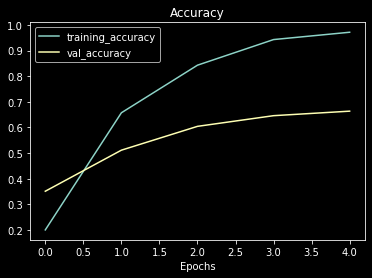

In [32]:
# How do the model with 1% of the data and data augmentation loss curves look
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [33]:
# Get 10% of data...
import os
if not os.path.exists("10_food_classes_10_percent.zip"):
    !python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
    unzip_data("10_food_classes_10_percent.zip")

In [34]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [35]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [36]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outpur (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # we pass the augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Creating a model checkpoint callback

The ModelCheckpoint callback intermediatly saves our model (the full model or just the weights) during training. This is useful, so we can come back and start where we left off.

In [37]:
# Set checkpoint path
checkpoint_path = "10_percent_mode_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=True,
    save_freq="epoch", # save every epoch
    verbose=0
)

In [38]:
# Fit
history_2 = model_2.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="10_percent_data_aug"
        ),
        checkpoint_callback
    ]
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220627-052815
Epoch 1/5
24/24 [==============================] - 21s 692ms/step - loss: 2.0240 - accuracy: 0.3093 - val_loss: 1.5258 - val_accuracy: 0.6431
INFO:tensorflow:Assets written to: 10_percent_mode_checkpoints_weights\checkpoint.ckpt\assets


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
24/24 [==============================] - 15s 593ms/step - loss: 1.3593 - accuracy: 0.6893 - val_loss: 1.0724 - val_accuracy: 0.7714
INFO:tensorflow:Assets written to: 10_percent_mode_checkpoints_weights\checkpoint.ckpt\assets


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/5
24/24 [==============================] - 11s 437ms/step - loss: 1.0513 - accuracy: 0.7453 - val_loss: 0.8607 - val_accuracy: 0.7895
INFO:tensorflow:Assets written to: 10_percent_mode_checkpoints_weights\checkpoint.ckpt\assets


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/5
24/24 [==============================] - 11s 445ms/step - loss: 0.9113 - accuracy: 0.7693 - val_loss: 0.7813 - val_accuracy: 0.8010
INFO:tensorflow:Assets written to: 10_percent_mode_checkpoints_weights\checkpoint.ckpt\assets


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/5
24/24 [==============================] - 12s 503ms/step - loss: 0.7915 - accuracy: 0.7960 - val_loss: 0.6925 - val_accuracy: 0.8141
INFO:tensorflow:Assets written to: 10_percent_mode_checkpoints_weights\checkpoint.ckpt\assets


c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [39]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 9s 96ms/step - loss: 0.6227 - accuracy: 0.8340


[0.6227174997329712, 0.8339999914169312]

In [40]:
# Check model_2 results on all test_Data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 8s 94ms/step - loss: 0.6935 - accuracy: 0.8044


[0.6934772729873657, 0.8044000267982483]

In [41]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


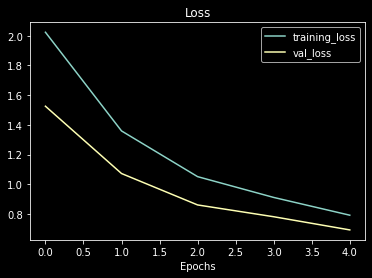

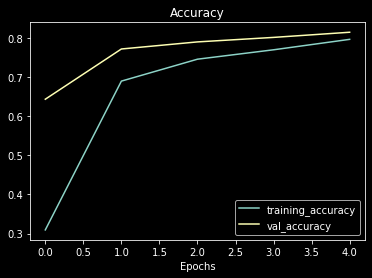

In [42]:
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [43]:
# Load in save model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [44]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)
loaded_weights_model_results

79/79 [==============================] - 8s 94ms/step - loss: 0.6935 - accuracy: 0.8044


[0.6934768557548523, 0.8044000267982483]

In [45]:
# If the results from our previously evaluated model_2 match the loaded weights, everythin has worked
results_10_percent_data_aug == loaded_weights_model_results

False

In [46]:
# Check to see if loaded model results are very close to our previous non-loaded model results

In [47]:
import numpy as np
np.isclose(np.array(loaded_weights_model_results), np.array(results_10_percent_data_aug))

array([ True,  True])

## Model 3: Fine-tuning an existing model on 10% of data

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [48]:
# Layers in loaded model
model_2.layers

In [49]:
# Are these layers trainable?

In [50]:
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002D770B18310> True
<keras.engine.sequential.Sequential object at 0x000002D770B18940> True
<keras.engine.functional.Functional object at 0x000002D77D56F760> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x000002D76E828040> True
<keras.layers.core.Dense object at 0x000002D7D94EC2E0> True


In [51]:
# What layers are in our base_model (EfficientNetB2) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [52]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [53]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=["accuracy"]
)

c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


> 🔑 **Note:** When tuning it's best practive to lower your learning rate by some amount. How much? This is a hyperparemeter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is the ILMFiT paper: https://arxiv.org/abs/1801.06146

In [54]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [55]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are ther?
print(len(model_2.trainable_variables))
model_2.trainable_variables

12


[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [56]:
# Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs=fine_tune_epochs,
    validation_data=test_data,
    validation_steps=len(test_data),
    initial_epoch=history_2.epoch[-1], # start training from previous last epoch
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="10_percent_fine_tune_last_10"
        )
    ]
)

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220627-053207
Epoch 5/10
24/24 [==============================] - 25s 835ms/step - loss: 0.7083 - accuracy: 0.8107 - val_loss: 0.5672 - val_accuracy: 0.8124
Epoch 6/10
24/24 [==============================] - 17s 713ms/step - loss: 0.5854 - accuracy: 0.8227 - val_loss: 0.5308 - val_accuracy: 0.8216
Epoch 7/10
24/24 [==============================] - 16s 692ms/step - loss: 0.5022 - accuracy: 0.8560 - val_loss: 0.5104 - val_accuracy: 0.8240
Epoch 8/10
24/24 [==============================] - 16s 657ms/step - loss: 0.4476 - accuracy: 0.8587 - val_loss: 0.4932 - val_accuracy: 0.8296
Epoch 9/10
24/24 [==============================] - 15s 647ms/step - loss: 0.4080 - accuracy: 0.8800 - val_loss: 0.4997 - val_accuracy: 0.8280
Epoch 10/10
24/24 [==============================] - 15s 618ms/step - loss: 0.3916 - accuracy: 0.8707 - val_loss: 0.4797 - val_accuracy: 0.8348


In [57]:
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 7s 92ms/step - loss: 0.4797 - accuracy: 0.8348


[0.47969427704811096, 0.8348000049591064]

In [58]:
results_10_percent_data_aug

[0.6934772729873657, 0.8044000267982483]

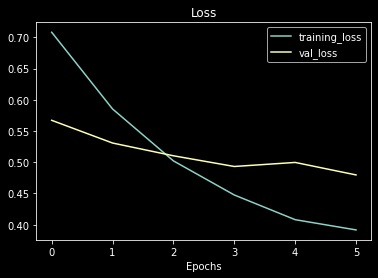

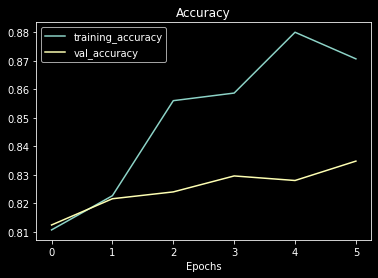

In [59]:
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [93]:
# Let's create a function 
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

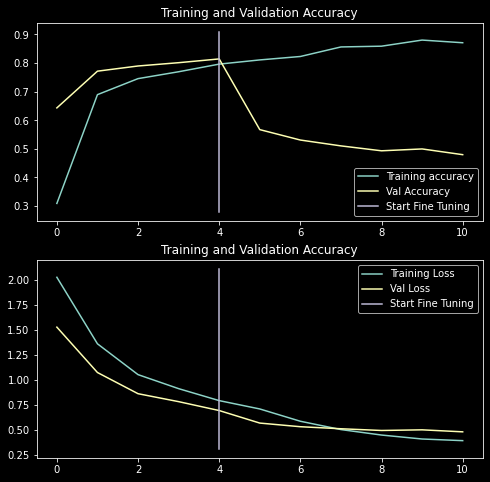

In [61]:
compare_historys(
    history_2,
    history_fine_10_percent_data_aug,
    epochs=5
)

## Model 4: Fine-tuning an existing model on all of the data

In [65]:
# Download and unzip 10 classes of Food101 data with all images
import os

if not os.path.exists("10_food_classes_all_data/"):
    !python -m wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
    unzip_data("10_food_classes_all_data.zip")



Saved under 10_food_classes_all_data.zip


In [66]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [67]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data/")

There are 2 directories and 0 images in '10_food_classes_all_data/'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test\sushi'.
There are

In [68]:
# Setup data input
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_classes_all_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=32
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for privious experiments (all experiments have used the same dataset).

Let's verify this...

In [69]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.4797 - accuracy: 0.8348


[0.4796943962574005, 0.8348000049591064]

In [71]:
results_fine_tune_10_percent

[0.47969427704811096, 0.8348000049591064]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [72]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [73]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.6935 - accuracy: 0.8044


[0.6934764981269836, 0.8044000267982483]

In [74]:
# Check to sse if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6934772729873657, 0.8044000267982483]

Allright, the previous steps might seem quite confusing, but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10 % of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint`Callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to to the same steps as step 2, except this time we're going to use all of the data (model_4)

In [75]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [77]:
# Let's drill into our base_model (EfficientNetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [81]:
# Compile
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=["accuracy"]
)

c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [82]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(
    train_data_10_classes_all_data,
    epochs=fine_tune_epochs,
    #steps_per_epoch=len(train_data_10_classes_all_data),
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    initial_epoch=history_2.epoch[-1],
    callbacks=[
        create_tensorboard_callback(
            dir_name="transfer_learning",
            experiment_name="full_10_classes_fine_tune_last_10"
        )
    ]
)

c:\Users\gutsc\anaconda3\envs\udemy_tensorflow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220627-060638
Epoch 5/10
235/235 [==============================] - 65s 256ms/step - loss: 0.5507 - accuracy: 0.8215 - val_loss: 0.3848 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - 59s 250ms/step - loss: 0.4867 - accuracy: 0.8437 - val_loss: 0.3477 - val_accuracy: 0.8832
Epoch 7/10
235/235 [==============================] - 52s 222ms/step - loss: 0.4583 - accuracy: 0.8509 - val_loss: 0.3725 - val_accuracy: 0.8766
Epoch 8/10
235/235 [==============================] - 49s 209ms/step - loss: 0.4300 - accuracy: 0.8580 - val_loss: 0.3309 - val_accuracy: 0.8898
Epoch 9/10
235/235 [==============================] - 47s 198ms/step - loss: 0.3972 - accuracy: 0.8723 - val_loss: 0.3116 - val_accuracy: 0.8964
Epoch 10/10
235/235 [==============================] - 45s 192ms/step - loss: 0.3801 - accuracy: 0.8768 - val_loss: 0.3100 - val_accuracy: 0.9013


In [85]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 90ms/step - loss: 0.2954 - accuracy: 0.9056


[0.29535579681396484, 0.9056000113487244]

5
11
[0.30933332443237305, 0.6893333196640015, 0.7453333139419556, 0.7693333625793457, 0.7960000038146973, 0.8214666843414307, 0.8437333106994629, 0.850933313369751, 0.8579999804496765, 0.8722666501998901, 0.876800000667572]


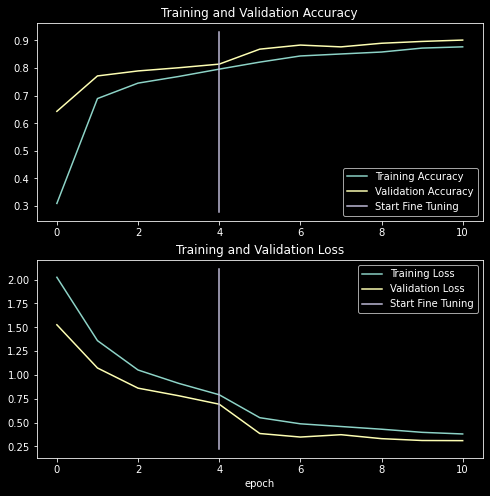

In [95]:
# How did fine-tuning fo with more data?
compare_historys(
    history_2, 
    history_fine_10_classes_full, 
    initial_epochs=5)